In [3]:
import sys, time, os, asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from lsst_efd_client import EfdClient
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def add_timestamp( data):
        """
        Adds a correct timestamp column in UTC format to the provided data if
        not present.

        Parameters
        ----------
        data : DataFrame
            The data to which the timestamp will be added.

        Returns
        -------
        DataFrame
            The data with the added 'snd_timestamp_utc' column.
        """
        if "snd_timestamp_utc" not in data.columns:
            data["snd_timestamp_utc"] = Time(
                data["private_sndStamp"], format="unix_tai"
            ).unix
        return data
def get_data(events_frame, client, train=False):
    table_dict={"m1m3_hp_actuator":"lsst.sal.MTM1M3.hardpointActuatorData",
                #"m1m3_hp_monitor": "lsst.sal.MTM1M3.hardpointMonitorData",
                "mtmount_elevation": "lsst.sal.MTMount.elevation",
                "mtmount_azimuth": "lsst.sal.MTMount.azimuth",
                "m1m3_ims": "lsst.sal.MTM1M3.imsData"}
    query_dict={}
    for key in table_dict.keys():
        query_dict[key]=[]
    for j , time in tqdm(enumerate(events_frame["times"])):
        event_time=Time(events_frame["times"][j]-2, format="unix")
        for key in table_dict.keys():

                query=getEfdData(client, 
                                 table_dict[key],  
                                begin=event_time, 
                                end=event_time, 
                                prePadding=20, 
                                postPadding=20)
                query["event_num"]=j
                query = add_timestamp(query)
                query["oscillation_bool"]=0
                query["delta_time"] = query["snd_timestamp_utc"] - events_frame["times"][j] +3 
                if train:
                    sel = (query["delta_time"] >= -5)
                    sel &= (query["delta_time"] < 1)
                    query.loc[sel,"oscillation_bool"]=1

                query_dict[key].append(query)
    for key in table_dict.keys():
        query_dict[key]=pd.concat(query_dict[key])
    sorted_keys = sorted(query_dict.keys())
    initial_key = sorted_keys[0]
    merged_df = query_dict[initial_key].sort_index()
    # Define your tolerance for matching
    tolerance = 0.03# pd.Timedelta('0.03 seconds')

    # Iterate over the remaining DataFrames and merge them
    for key in sorted_keys[1:]:
        merged_df = pd.merge_asof(merged_df, query_dict[key].sort_index(), 
                                  left_on="snd_timestamp_utc", 
                                  right_on="snd_timestamp_utc", tolerance=tolerance, direction='nearest',
                                  suffixes=('', "_"+key))
    merged_df.reset_index(drop=True, inplace=True)
    
    return merged_df

In [5]:
client = EfdClient("idf_efd")
events_frame=pd.read_csv('./sitcomtn81_data/231114_cleaned_oscillations_final.csv')

merged_df = get_data(events_frame, client)



434it [08:14,  1.14s/it]


In [19]:
def get_stats(data):
    keys = [f"measuredForce{n}" for n in range(5)]
    max_val=np.max(data[key])
    min_val=np.min(data[key])
    ptp = np.ptp(data[key])
    before_std = np.std(data.loc[(data["delta_time"].values < 0), key])
    rolling_std = data["measuredForce2"].rolling(100).std()
    max_time = data.iloc[np.argmax(data[key]),:]["delta_time"]
    sel_time = (data["delta_time"] > max_time) & (rolling_std <=before_std + 10) 
    
    if sel_time.sum() > 0:
        duration = np.min(data.loc[sel_time,"delta_time"].values)
        return max_val, min_val, ptp,duration
    else:
        return max_val, min_val, ptp
    
def get_stats(data):
    # Create an empty DataFrame to store the results
    stats_df = pd.DataFrame(columns=["name", "Max Value", "Min Value", "Peak-to-Peak", "Duration"])

    # Define the keys
    keys = [f"measuredForce{n}" for n in range(6)]
    rows = []
    for key in keys:
        sel_0 = (data["delta_time"] > 0)
        max_val = max(data.loc[sel_0, key], key=abs)
        #min_val = np.min(data.loc[sel_0, key])
        ptp = np.ptp(data.loc[sel_0, key])
        before_std = np.std(data.loc[(data["delta_time"].values < 0), key])
        before_mean=np.mean(data.loc[(data["delta_time"].values < 0), key])
        rolling_std = data[key].rolling(100).std()
        max_time = data.iloc[np.argmax(data[key]),:]["delta_time"]
        sel_time = (data["delta_time"] > max_time) & (rolling_std <= before_std * 2) & sel_0

        # Calculate duration if condition is met
        if sel_time.sum() > 0:
            duration = np.min(data.loc[sel_time, "delta_time"].values)
        else:
            duration = np.nan  # Use NaN for cases where the condition is not met

        # Create a row dictionary and append to the list
        row = {"key": key, "max": max_val, "mean": before_mean, "ptp": ptp, "duration": duration}
        rows.append(row)
    stats_df = pd.DataFrame(rows)
    
    return stats_df

In [22]:
df_list = []
for i in np.unique(merged_df["event_num"]):
    sel = (merged_df["event_num"] == i)
    stats_df = get_stats(merged_df[sel])
    stats_df["day_obs"] = events_frame['day_obs'].values[i]
    stats_df["seq_num"] = events_frame['seq_num'].values[i]
    stats_df["elevation_velocity"] = events_frame['elevation_velocity'].values[i]
    stats_df["time"] = events_frame['times'].values[i] + 3
    df_list.append(stats_df)
stats_df =  pd.concat(df_list)

In [39]:
stats_df.to_csv("./sitcomtn81_data/gpt_stats.csv", index=False)

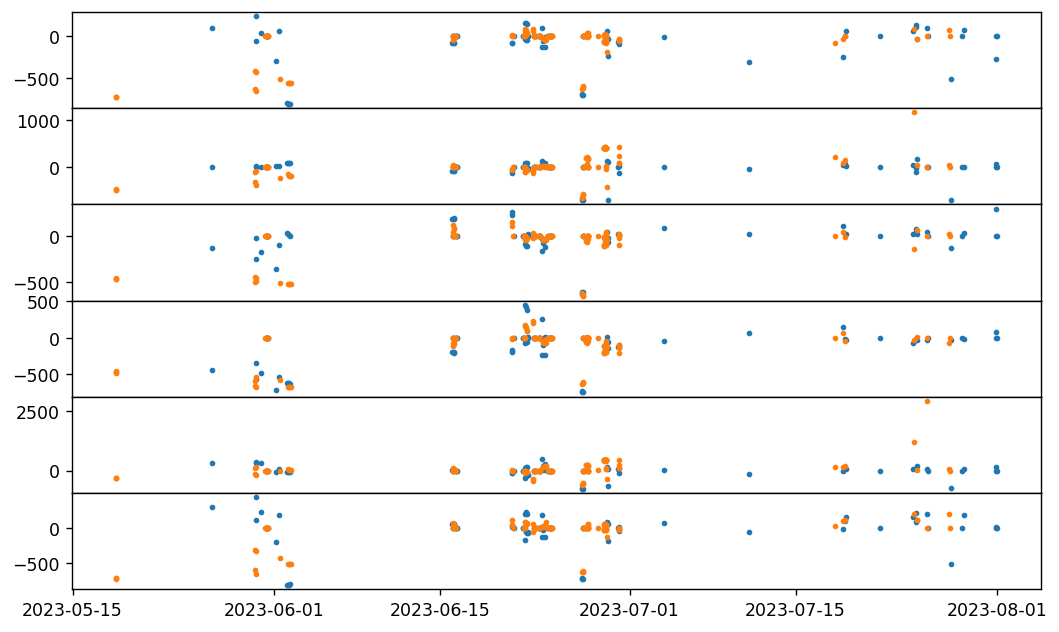

In [37]:
fig, axs=plt.subplots(6,1,dpi=125, figsize=(10,6), sharex=True)
for i,key in enumerate(np.unique(stats_df["key"])[:]):
    sel=(stats_df["key"]==key) & (abs(stats_df["elevation_velocity"]) > 1e-2)
    sel&=(stats_df["elevation_velocity"] < 0)
    ax=axs[i]
    ax.scatter(Time(stats_df.loc[sel,"time"], format="unix").datetime,
                stats_df.loc[sel,"mean"],
                label=key, s=5)
for i,key in enumerate(np.unique(stats_df["key"])[:]):
    sel=(stats_df["key"]==key) & (abs(stats_df["elevation_velocity"]) > 1e-2)
    sel&=(stats_df["elevation_velocity"] > 0)
    ax=axs[i]
    ax.scatter(Time(stats_df.loc[sel,"time"], format="unix").datetime,
                stats_df.loc[sel,"mean"],
                label=key, s=5)
    # ax=axs[1]
    # ax.scatter(Time(stats_df.loc[sel,"time"], format="unix").datetime,
    #             stats_df.loc[sel,"ptp"],
    #             label=key, s=5)
    # ax=axs[2]
    # ax.scatter(Time(stats_df.loc[sel,"time"], format="unix").datetime,
    #             stats_df.loc[sel,"mean"],
    #             label=key, s=5)
#ax.legend(ncol=3)
plt.subplots_adjust(hspace=0)

In [116]:
subframe["actualPosition"]

19994   -29.661136
19995   -29.661136
19996          NaN
19997          NaN
19998   -29.661136
           ...    
21989   -29.661134
21990   -29.661134
21991   -29.661134
21992   -29.661134
21993          NaN
Name: actualPosition, Length: 2000, dtype: float64

(-5.0, 5.0)

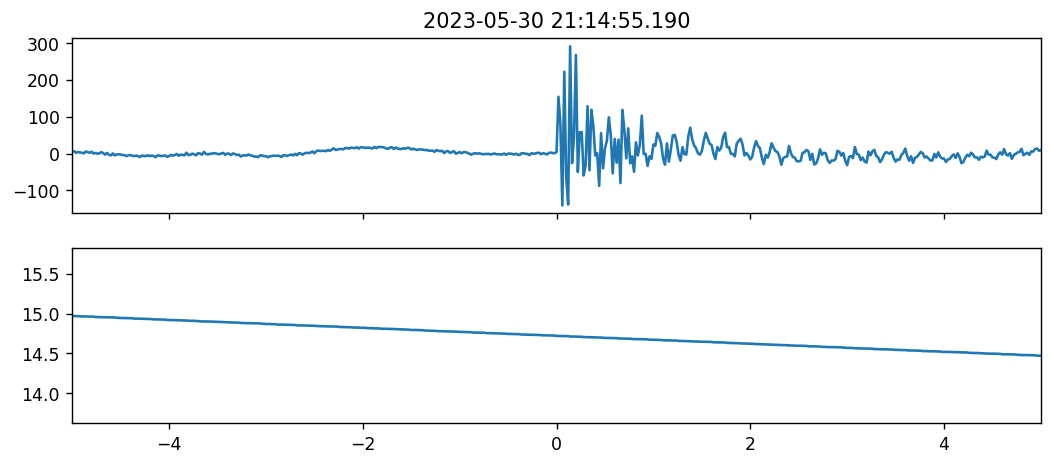

In [121]:
i=355
fig, axs=plt.subplots(2,1,dpi=125, figsize=(10,4), sharex=True)
subframe=merged_df[merged_df["event_num"]==i]
ax=axs[0]
times=Time(subframe["delta_time"], format="unix").datetime
times=subframe["delta_time"] -1
ax.set_title(Time(events_frame.loc[i,"times"], format="unix").iso)
ax.plot(times,
                subframe["measuredForce1"],
                label=key)
ax=axs[1]
sel=(~np.isnan(subframe["actualPosition_mtmount_elevation"]))
ax.plot(times[sel],
                subframe["actualPosition_mtmount_elevation"][sel],
                label=key)
sel=(~np.isnan(subframe["actualPosition"]))
# ax.plot(times[sel],
#                 subframe["actualPosition"][sel],
#                 label=key)
ax.set_xlim(-5,5)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

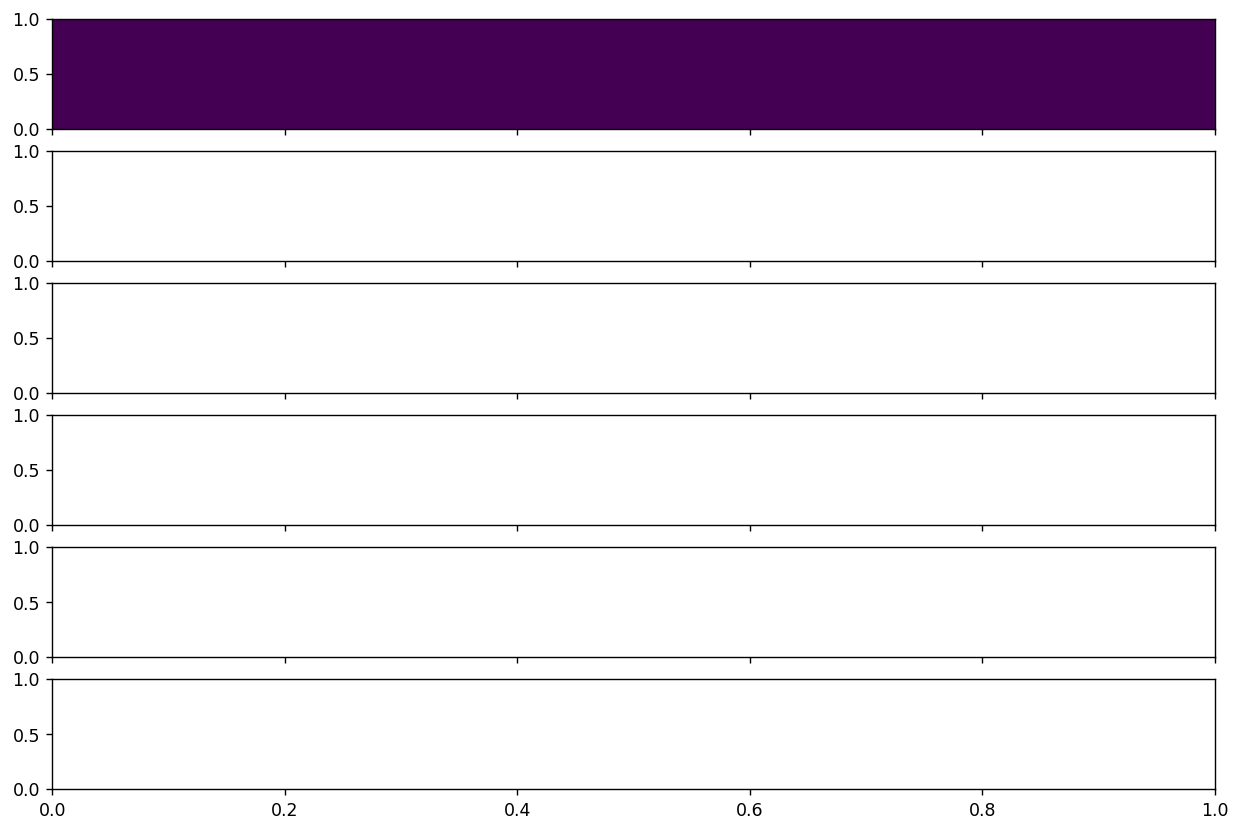

In [74]:
fig, axs=plt.subplots(6,1,dpi=125, figsize=(12,8), sharex=True)
for i,key in enumerate(np.unique(stats_df["key"])[:]):
    sel=(stats_df["key"]==key) & (abs(stats_df["elevation_velocity"]) > 1e-2)
    sel&=(stats_df["elevation_velocity"] > 0) & (stats_df["mean"] > 100)
    ax=axs[i]
    ax.hist2d(Time(stats_df.loc[sel,"time"], format="unix").datetime,
                stats_df.loc[sel,"mean"])#,
                #label=key, s=5)

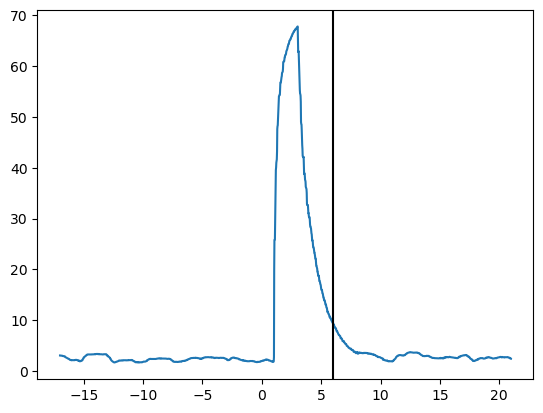

In [79]:
event_num = 0
sel = (merged_df["event_num"] == event_num)
times=Time(merged_df.loc[sel,"snd_timestamp_utc"], format="unix")
plt.plot(merged_df.loc[sel,"delta_time"] , 
            merged_df.loc[sel,"measuredForce2"].rolling(100).std(),
           )
plt.axvline(6, c="k")